# Composite Imaging Workflow (Solution)

This notebook walks through a full **subject compositing workflow**:

1. **Load** a subject image and a background image.
2. Use an **interactive masking script** (`SOL_interactive_masking.py`) to draw a polygon mask.
3. **Refine** the polygon mask and create a refined subject cut-out.
4. Use an external **interactive placement script** (`SOL_interactive_placement.py`) to choose where the subject goes on the background.
5. **Blend** the refined subject into the background with basic color/lighting adjustments.


In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

workflow_dir = "composite_workflow"
%matplotlib inline

### Step 1: Load subject and background images

We will start by loading:

- A **subject** image.
- A **background** image.

You can swap these for other images by changing the file paths below.

In [52]:
subject_path = "images/car.jpeg"
background_path = "images/jungle.jpg"

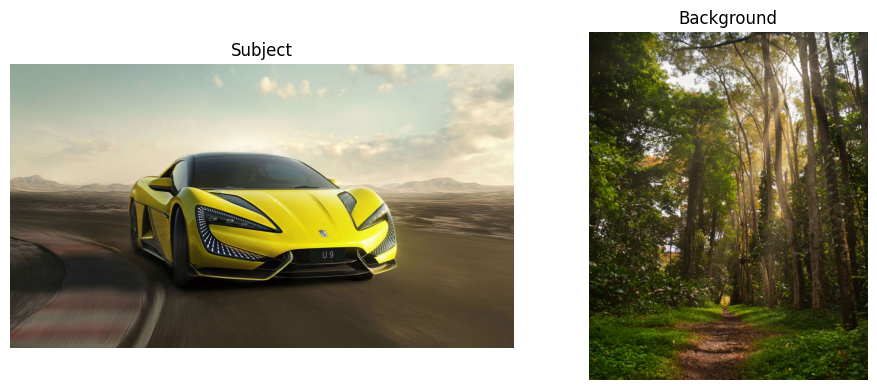

In [53]:
# STEP 1: Load subject and background images from the original dataset

subject_bgr = cv2.imread(subject_path)
background_bgr = cv2.imread(background_path)

subject = cv2.cvtColor(subject_bgr, cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(background_bgr, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(subject)
axes[0].set_title("Subject")
axes[0].axis("off")

axes[1].imshow(background)
axes[1].set_title("Background")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Step 2: Run the interactive masking script

To get a good subject cut-out, we will:

1. Save the subject image to a fixed path for the masking script.
2. Run `SOL_interactive_masking.py` from a terminal.
3. Draw a polygon around the subject in the OpenCV window.
4. Press **Enter** to save the mask.

The script will save:
- `04-Composites/images/polygon_mask.npy`
- `04-Composites/images/polygon_mask_preview.png`

In [ ]:
# Save subject for SOL_interactive_masking.py
subject_for_mask_path = "composite_workflow/subject_for_mask.png"

cv2.imwrite(subject_for_mask_path, cv2.cvtColor(subject, cv2.COLOR_RGB2BGR))
print(f"Saved subject for masking script to: {subject_for_mask_path}")
print("In a terminal, run:\n")
print("  python SOL_interactive_masking.py \\")
print("      --image composite_workflow/subject_for_mask.png \\")
print("      --output-mask composite_workflow/polygon_mask.npy \\")
print("      --output-preview composite_workflow/polygon_mask_preview.png")

Saved subject for masking script to: composite_workflow/subject_for_mask.png
In a terminal, run:

  python SOL_interactive_masking.py \
      --image composite_workflow/subject_for_mask.png \
      --output-mask composite_workflow/polygon_mask.npy \
      --output-preview composite_workflow/polygon_mask_preview.png


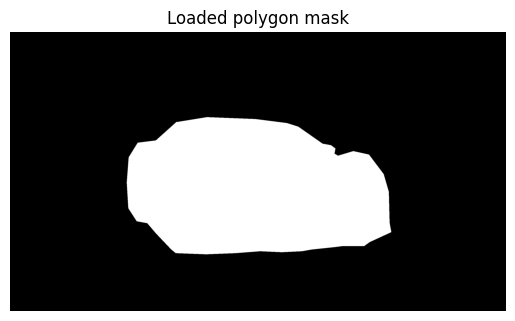

In [36]:
# STEP 3: Load the polygon mask produced by SOL_interactive_masking.py

mask_npy_path = os.path.join(workflow_dir, "polygon_mask.npy")

poly_mask = np.load(mask_npy_path).astype(np.float32)

plt.imshow(poly_mask, cmap="gray")
plt.title("Loaded polygon mask")
plt.axis("off")
plt.show()

### Step 3: Refine the mask and create a refined subject cut-out

We're going to use the polygon mask as a starting point. We're going to improve it using the following steps:

- **Optional**: Feather the edges slightly.
- Apply the refined mask to the subject to produce a **refined subject image**.

We will save:
- `04-Composites/composite_workflow/refined_mask.npy`
- `04-Composites/composite_workflow/refined_subject.png`

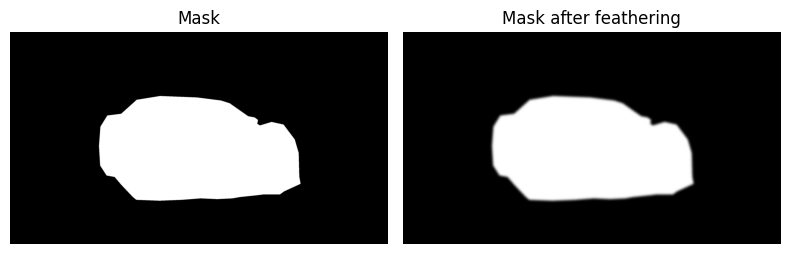

In [63]:
# STEP 4A: Feather the cleaned mask for smoother edges
# * Blur the cleaned mask and normalize it back to [0, 1].

feather_ksize = 51  # must be odd
feathered = cv2.GaussianBlur(poly_mask, (feather_ksize, feather_ksize), 0)

min_val, max_val = feathered.min(), feathered.max()
if max_val > min_val:
    feathered = (feathered - min_val) / (max_val - min_val)

refined_mask = np.clip(feathered, 0.0, 1.0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(poly_mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(refined_mask, cmap="gray")
plt.title("Mask after feathering")
plt.axis("off")

plt.tight_layout()
plt.show()

Saved refined mask to: composite_workflow/refined_mask.npy
Saved refined subject to: composite_workflow/refined_subject.png


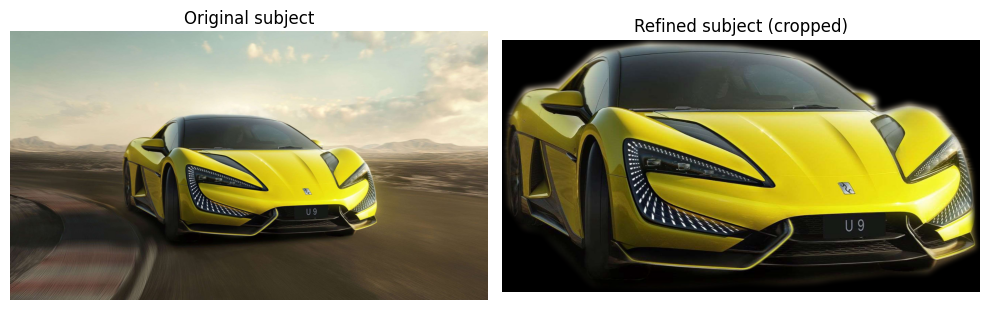

In [65]:
# STEP 4B: Apply the refined mask to create a cropped subject image
# * Multiply the subject by the refined mask and crop to the tight bounding box.

subject_float = subject_bgr.astype(np.float32) / 255.0
mask_3c = np.dstack([refined_mask] * 3)

refined_subject_float = subject_float * mask_3c
refined_subject_bgr = (refined_subject_float * 255).astype(np.uint8)

# Build an RGBA image using refined_mask as alpha
alpha = (refined_mask * 255).astype(np.uint8)
refined_subject_bgra_full = cv2.merge([
    refined_subject_bgr[:, :, 0],
    refined_subject_bgr[:, :, 1],
    refined_subject_bgr[:, :, 2],
    alpha,
])

# Crop to tight bounding box so the refined subject image is smaller
ys, xs = np.where(refined_mask > 0.05)
if len(ys) == 0:
    raise ValueError("Refined mask is empty; cannot create refined subject.")

y1, y2 = ys.min(), ys.max()
x1, x2 = xs.min(), xs.max()

refined_mask_cropped = refined_mask[y1:y2+1, x1:x2+1]
refined_subject_bgra = refined_subject_bgra_full[y1:y2+1, x1:x2+1, :]
refined_subject_bgr_cropped = refined_subject_bgr[y1:y2+1, x1:x2+1, :]

refined_mask_path = os.path.join(workflow_dir, "refined_mask.npy")
refined_subject_path = os.path.join(workflow_dir, "refined_subject.png")

np.save(refined_mask_path, refined_mask_cropped.astype(np.float32))
cv2.imwrite(refined_subject_path, refined_subject_bgra)

print(f"Saved refined mask to: {refined_mask_path}")
print(f"Saved refined subject to: {refined_subject_path}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(subject)
plt.title("Original subject")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(refined_subject_bgr_cropped, cv2.COLOR_BGR2RGB))
plt.title("Refined subject (cropped)")
plt.axis("off")

plt.tight_layout()
plt.show()

### Step 4: Use the interactive placement script

Now that we have a refined subject image, we will choose **where** it should appear in the background **and how large it should be**.

We will:

1. Save a copy of the background to a fixed path for the placement script.
2. Run `SOL_interactive_placement.py` from a terminal to drag the subject into place **and resize it**.
   * Click and drag to move the subject.
   * Press `+` / `=` to scale up, `-` to scale down, `r` to reset.
3. Save the chosen top-left `(y, x)` coordinates to `placement_info.npy`.

The script will save:
- `composite_workflow/placement_info.npy`

In [66]:
# Save background for SOL_interactive_placement.py
background_for_place_path = "composite_workflow/background_for_composite.jpg"

cv2.imwrite(background_for_place_path, cv2.cvtColor(background, cv2.COLOR_RGB2BGR))
print(f"Saved background for placement script to: {background_for_place_path}")
print("In a terminal, run:\n")
print("  python SOL_interactive_placement.py \\")
print("      --subject composite_workflow/refined_subject.png \\")
print("      --background composite_workflow/background_for_composite.jpg \\")
print("      --output-placement composite_workflow/placement_info.npy")

Saved background for placement script to: composite_workflow/background_for_composite.jpg
In a terminal, run:

  python SOL_interactive_placement.py \
      --subject composite_workflow/refined_subject.png \
      --background composite_workflow/background_for_composite.jpg \
      --output-placement composite_workflow/placement_info.npy


In [67]:
# STEP 6: Load placement info produced by SOL_interactive_placement.py
# * The placement script saved the final top-left (y, x) coordinates into `placement_info.npy`.
placement_path = "composite_workflow/placement_info.npy"

placement_info = np.load(placement_path, allow_pickle=True).item()
place_y = int(placement_info["y"])
place_x = int(placement_info["x"])

print("Using placement (y, x):", (place_y, place_x))

Using placement (y, x): (1635, 190)


### Step 7: Composite the refined subject onto the background (no color adjustment)

We now have:

- `composite_workflow/refined_subject.png` – the cropped, refined subject with transparency.
- `composite_workflow/refined_mask.npy` – the refined (cropped) mask.
- `composite_workflow/placement_info.npy` – the chosen top-left `(y, x)` placement and scale for the subject.

In this step we will:

1. Load the refined subject, mask, and placement (including **scale**).
2. Resize the refined subject and mask according to the saved scale.
3. Alpha-blend the subject into the background using the refined mask.
4. Preview the composite **before** any color blending and save it.

Placement (y, x, scale): (1635, 190, 1.0)


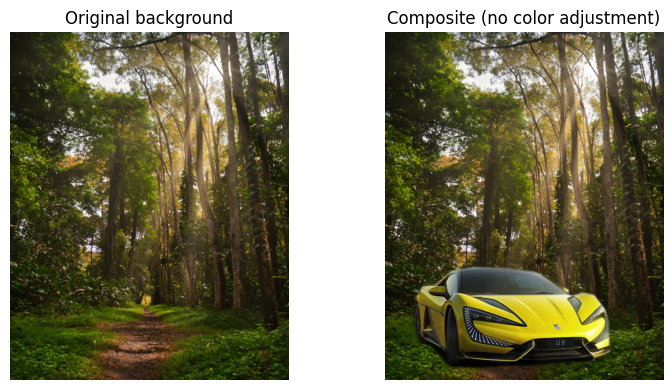

Saved no-color composite to: composite_workflow/composite_no_color.jpg


In [68]:
# STEP 7: Geometry-only composite preview (no color adjustment)
# * Load the refined subject, refined mask, and placement (including scale).
# * Resize the subject and mask according to the saved scale factor.
# * Alpha-blend the subject into the background using the refined mask.
# * Preview the composite before any color blending and save it.

# Load refined subject (with alpha) and refined mask from disk
refined_subject_path = os.path.join(workflow_dir, "refined_subject.png")
refined_mask_path = os.path.join(workflow_dir, "refined_mask.npy")
placement_path = os.path.join(workflow_dir, "placement_info.npy")

refined_subj_bgra = cv2.imread(refined_subject_path, cv2.IMREAD_UNCHANGED)
if refined_subj_bgra is None:
    raise FileNotFoundError(f"Could not load refined subject at {refined_subject_path}")

refined_mask_cropped = np.load(refined_mask_path).astype(np.float32)
placement_info = np.load(placement_path, allow_pickle=True).item()
place_y = int(placement_info["y"])
place_x = int(placement_info["x"])
scale = float(placement_info.get("scale", 1.0))

print("Placement (y, x, scale):", (place_y, place_x, scale))

# Resize subject and mask according to the saved scale
orig_h, orig_w = refined_subj_bgra.shape[:2]
new_w = max(1, int(orig_w * scale))
new_h = max(1, int(orig_h * scale))

refined_subj_bgra_scaled = cv2.resize(refined_subj_bgra, (new_w, new_h), interpolation=cv2.INTER_AREA)
refined_mask_scaled = cv2.resize(refined_mask_cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)
refined_mask_scaled = np.clip(refined_mask_scaled, 0.0, 1.0)

# Split channels
if refined_subj_bgra_scaled.shape[2] == 4:
    subj_bgr = refined_subj_bgra_scaled[:, :, :3]
    subj_alpha = refined_subj_bgra_scaled[:, :, 3].astype(np.float32) / 255.0
else:
    subj_bgr = refined_subj_bgra_scaled
    subj_alpha = refined_mask_scaled  # fall back to mask if no alpha channel

# Convert to float RGB for processing
subj_rgb = cv2.cvtColor(subj_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
bg_rgb = background.astype(np.float32) / 255.0

bg_h, bg_w = bg_rgb.shape[:2]
subj_h, subj_w = subj_rgb.shape[:2]

# Clip placement if needed
end_y = min(bg_h, place_y + subj_h)
end_x = min(bg_w, place_x + subj_w)

sub_h = end_y - place_y
sub_w = end_x - place_x

subj_region_rgb = subj_rgb[:sub_h, :sub_w, :]
mask_region = refined_mask_scaled[:sub_h, :sub_w]
alpha_region = subj_alpha[:sub_h, :sub_w]

bg_region_rgb = bg_rgb[place_y:end_y, place_x:end_x, :]

# Alpha for compositing (combine mask + alpha channel)
alpha_combined = np.clip(mask_region, 0.0, 1.0) * np.clip(alpha_region, 0.0, 1.0)
alpha_3c = np.dstack([alpha_combined] * 3)

# Blend subject (no color shift yet) into background copy
composite_no_color_rgb = bg_rgb.copy()
region_bg = composite_no_color_rgb[place_y:end_y, place_x:end_x, :]

blended_region = subj_region_rgb * alpha_3c + region_bg * (1.0 - alpha_3c)
composite_no_color_rgb[place_y:end_y, place_x:end_x, :] = blended_region

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(background)
plt.title("Original background")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(composite_no_color_rgb)
plt.title("Composite (no color adjustment)")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the no-color composite for reference
no_color_out_path = os.path.join(workflow_dir, "composite_no_color.jpg")
cv2.imwrite(no_color_out_path, cv2.cvtColor((composite_no_color_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print(f"Saved no-color composite to: {no_color_out_path}")

# Keep key variables in memory for the color-blending step
subj_region_rgb_no_color = subj_region_rgb
bg_region_rgb_no_color = bg_region_rgb
mask_region_no_color = mask_region
alpha_region_no_color = alpha_region
composite_base_rgb = composite_no_color_rgb

### Step 8: Color-blend the subject with the background

Now that we have a geometric composite with correct placement and size, we can make the subject **better match the lighting and color** of the background.

In this step we will:

* Compute color statistics only where the subject overlaps the background.
* Shift the subject colors toward the background colors using a tunable `color_blend_strength`.
* Visualize the subject region **before and after** color adjustment.
* Apply the color-adjusted subject back into the composite and save the final result.

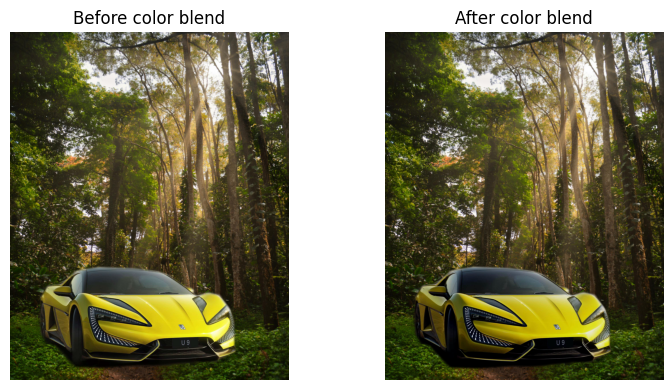

Saved final composite to: composite_workflow/final_composite_solution.jpg


In [69]:
# STEP 8: Simple color blending on top of the geometric composite
# * Compute mean colors for subject and background only where the subject overlaps.
# * Shift subject colors toward background colors with a single strength parameter.
# * Blend the adjusted subject back into the no-color composite.

# Tunable strength: 0 = no change, 1 = fully match background mean
color_blend_strength = 0.5
mask_threshold = 0.2  # which mask values count as "subject" for computing statistics

# Re-use regions from STEP 7
subj_region_rgb = subj_region_rgb_no_color
bg_region_rgb = bg_region_rgb_no_color
mask_region = mask_region_no_color
alpha_region = alpha_region_no_color

# 1. Compute color means where the subject is confidently present
subject_pixels = mask_region > mask_threshold
if not np.any(subject_pixels):
    raise ValueError("Mask threshold too high; no subject pixels found.")

subj_vals = subj_region_rgb[subject_pixels]
bg_vals = bg_region_rgb[subject_pixels]

subj_mean = subj_vals.mean(axis=0)
bg_mean = bg_vals.mean(axis=0)

# 2. Apply a simple per-channel shift toward the background mean
color_shift = bg_mean - subj_mean
adjusted_subj_region = subj_region_rgb + color_blend_strength * color_shift
adjusted_subj_region = np.clip(adjusted_subj_region, 0.0, 1.0)

# 3. Blend adjusted subject into the no-color composite
alpha_combined = np.clip(mask_region, 0.0, 1.0) * np.clip(alpha_region, 0.0, 1.0)
alpha_3c = np.dstack([alpha_combined] * 3)

composite_rgb = composite_base_rgb.copy()

h_region, w_region = adjusted_subj_region.shape[:2]
region_bg = composite_rgb[place_y:place_y + h_region, place_x:place_x + w_region, :]

composite_rgb[place_y:place_y + h_region, place_x:place_x + w_region, :] = (
    adjusted_subj_region * alpha_3c + region_bg * (1.0 - alpha_3c)
)

# 4. Quick before/after composite view
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(composite_base_rgb)
plt.title("Before color blend")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(composite_rgb)
plt.title("After color blend")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save final composite
final_out_path = os.path.join(workflow_dir, "final_composite_solution.jpg")
cv2.imwrite(final_out_path, cv2.cvtColor((composite_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print(f"Saved final composite to: {final_out_path}")